# Test Notebebook

This notebook will contain various tests and benchmarks of Neuopt.

In [ ]:
import os
import json
import torch
import pprint
import numpy as np
import random
from tensorboard_logger import Logger as TbLogger
import warnings

from problems.problem_tsp import TSP
from problems.problem_cvrp import CVRP
from agent.ppo import PPO
from tqdm.notebook import tqdm

import vrplib

Below, we initialize hyperparameters

In [32]:
from options import get_options
opts = get_options('')
opts

Namespace(problem='tsp', graph_size=20, dummy_rate=0.5, eval_only=False, init_val_met='random', no_cuda=False, no_tb=False, no_saving=False, no_DDP=False, use_assert=False, seed=6666, val_m=1, stall_limit=10, k=4, wo_regular=True, wo_bonus=True, wo_RNN=False, wo_feature1=True, wo_feature3=True, wo_MDP=True, load_path=None, resume=None, epoch_start=0, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, batch_size=512, epoch_end=200, epoch_size=10240, val_size=1000, val_batch_size=1000, val_dataset=None, lr_model=8e-05, lr_critic=2e-05, lr_decay=0.985, warm_up=2, max_grad_norm=0.05, v_range=6.0, critic_head_num=4, actor_head_num=4, embedding_dim=128, hidden_dim=128, n_encode_layers=3, normalization='layer', gamma=0.999, T_max=1000, no_progress_bar=False, log_dir='logs', log_step=50, record=False, output_dir='outputs', run_name='run_name_20251211T111742', checkpoint_epochs=1, wo_feature2=True, world_size=1, distributed=False, use_cuda=True, save_dir='outputs\\tsp_20\\run_name_20251211T111742

In [33]:
opts.problem = 'cvrp' 
opts.dummy_rate = 0.4
opts.wo_feature1 = False #feature1 corresponds to these two features : infeasibility_indicator_before_visit,infeasibility_indicator_after_visit. If wo_feature1 is False, then agent has those two features. 
opts.wo_feature3 = False #feature3 corresponds to exploration statistics (i think).
opts.wo_regular = False
opts.wo_bonus = False
opts.wo_RNN = False
opts.wo_MDP = True
opts.use_cuda = False
opts.graph_size = 100
opts.val_dataset='./datasets/cvrp_100.pkl'
opts.init_val_met = 'random'
opts.no_saving = True
opts.no_tb = True
opts.val_size = 10
opts.load_path = './pre-trained/cvrp100.pt'
opts.device = torch.device("cuda" if opts.use_cuda else "cpu")
opts.no_progress_bar = True
opts


Namespace(problem='cvrp', graph_size=100, dummy_rate=0.4, eval_only=False, init_val_met='random', no_cuda=False, no_tb=True, no_saving=True, no_DDP=False, use_assert=False, seed=6666, val_m=1, stall_limit=10, k=4, wo_regular=False, wo_bonus=False, wo_RNN=False, wo_feature1=False, wo_feature3=False, wo_MDP=True, load_path='./pre-trained/cvrp100.pt', resume=None, epoch_start=0, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, batch_size=512, epoch_end=200, epoch_size=10240, val_size=10, val_batch_size=1000, val_dataset='./datasets/cvrp_100.pkl', lr_model=8e-05, lr_critic=2e-05, lr_decay=0.985, warm_up=2, max_grad_norm=0.05, v_range=6.0, critic_head_num=4, actor_head_num=4, embedding_dim=128, hidden_dim=128, n_encode_layers=3, normalization='layer', gamma=0.999, T_max=1000, no_progress_bar=True, log_dir='logs', log_step=50, record=False, output_dir='outputs', run_name='run_name_20251211T111742', checkpoint_epochs=1, wo_feature2=True, world_size=1, distributed=False, use_cuda=False, save_d

In [62]:
from torch.utils.data import DataLoader
from problems.problem_cvrp import CVRPDataset

dataset1 = CVRPDataset(DUMMY_RATE=0.4, CVRPLib_paths=['XML/instances/XML100_1111_01.vrp','XML/instances/XML100_1111_02.vrp'], coords_norm_factor=1000)
batch1 = next(iter(DataLoader(dataset1, batch_size=2)))


dataset2 = CVRPDataset(size = 100, num_samples = 2, DUMMY_RATE=0.4)
batch2 = next(iter(DataLoader(dataset2, batch_size=2)))

print(batch1.keys() == batch2.keys())
print(type(batch1) == type(batch2))
print(batch1['coordinates'].size() == batch2['coordinates'].size())
print(batch1['demand'].size() == batch2['demand'].size())
print(type(batch1['coordinates']) == type(batch2['coordinates']))
print(type(batch1['demand']) == type(batch2['demand']))

2 instances initialized.
2 instances initialized.
True
True
True
True
True
True


In [63]:
problem = CVRP(
                p_size = 100,
                init_val_met = opts.init_val_met,
                with_assert = opts.use_assert,
                DUMMY_RATE = opts.dummy_rate,
                k = opts.k,
                with_bonus = not opts.wo_bonus,
                with_regular = not opts.wo_regular)

# Figure out the RL algorithm
agent = PPO(problem, opts)

# Load data from load_path
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)

CVRP with 100 nodes and 40 dummy depots (total 140).
 Regulation: True Bonus: True Do assert: False.
 MAX 4-opt.

simpleMDP:  True
# params in Actor {'Total': 685140, 'Trainable': 685140}
# params in Critic {'Total': 191107, 'Trainable': 191107}
Distributed: False
 [*] Loading data from ./pre-trained/cvrp100.pt


In [64]:
import torch
from matplotlib import pyplot as plt

def plot_tour(rec, coordinates, dpi = 300):
    real_seq = problem.get_order(rec.unsqueeze(0), return_solution = True)
    plt.figure(figsize=(8,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([-0.05, 1.05]*2)
    # plot the nodes
    plt.scatter(coordinates[:,0], coordinates[:,1], marker = 'H', s = 55, c = 'blue', zorder = 2)
    # plot the tour
    real_seq_coordinates = coordinates.gather(0,real_seq[0].unsqueeze(1).repeat(1,2))
    real_seq_coordinates = torch.cat((real_seq_coordinates, real_seq_coordinates[:1]),0)
    plt.plot(real_seq_coordinates[:,0], real_seq_coordinates[:,1], color = 'black', zorder = 1)
    # mark node
    for i,txt in enumerate(range(rec.size(0))):
        plt.annotate(txt,(coordinates[i,0]+0.01, coordinates[i,1]+0.01),)
    
    
    plt.show()

In [65]:
from utils import torch_load_cpu, get_inner_model, move_to
from problems.problem_cvrp import total_history
feasibility_history_base = [True] * (total_history)
T=500
val_m = 1
stall_limit = 0
record = True
show_bar = False

bs, gs, _ = batch1['coordinates'].size()
batch = move_to(batch1, agent.opts.device)
batch_aug_same = problem.augment(batch, val_m, only_copy=True)
batch_aug = problem.augment(batch, val_m)
batch_feature = problem.input_feature_encoding(batch_aug)

solutions = move_to(problem.get_initial_solutions(batch_aug_same), agent.opts.device)
solution_best = solutions.clone()

obj, context = problem.get_costs(batch_aug_same, solutions, get_context = True, check_full_feasibility = True)
obj = torch.cat((obj[:,None], obj[:,None],obj[:,None]),-1).clone()
context2 = torch.zeros(bs*val_m,9).to(solutions.device);context2[:,-1] = 1
feasibility_history = torch.tensor(feasibility_history_base).view(-1,total_history).expand(bs*val_m, total_history).to(obj.device)

solution_history = [solutions.clone()]
solution_best_history = [solution_best.clone()]
obj_history = [obj.clone()]        
feasible_history_recorded = [feasibility_history[:,0]]
action = None
reward = []
stall_cnt_ins = torch.zeros(bs * val_m).to(solution_best.device)

for t in tqdm(range(T), disable = agent.opts.no_progress_bar or not show_bar, desc = 'rollout', bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):       

    action = agent.actor(problem,
                        batch_aug_same,
                        batch_feature,
                        solutions,
                        context,
                        context2,
                        action)[0]

    solutions, rewards, obj, feasibility_history, context, context2, info = problem.step(batch_aug_same, 
                                                                                        solutions,
                                                                                        action,
                                                                                        obj,
                                                                                        feasibility_history,
                                                                                        t,
                                                                                        weights = 0)
    index = rewards[:,0] > 0.0
    solution_best[index] = solutions[index].clone()

    # record informations
    reward.append(rewards[:,0].clone())
    obj_history.append(obj.clone())
    if record: 
        solution_history.append(solutions.clone())
        solution_best_history.append(solution_best.clone())
        feasible_history_recorded.append(feasibility_history[:,0].clone())

    # augment if stall>0 (checking every step)
    if stall_limit > 0:
        batch_aug_temp = problem.augment(batch, val_m)
        stall_cnt_ins = stall_cnt_ins * (1 - index.float()) + 1
        index_aug = stall_cnt_ins >= stall_limit
        batch_aug['coordinates'][index_aug] = batch_aug_temp['coordinates'][index_aug]
        batch_feature = problem.input_feature_encoding(batch_aug)
        stall_cnt_ins[index_aug] *= 0


# assert
best_length = problem.get_costs(batch_aug_same, solution_best, get_context = False, check_full_feasibility = True)
assert (best_length - obj[:,1] < 1e-5).all(), (best_length, obj, best_length - obj[:,1])
assert (problem.augment(batch, val_m, only_copy=True)['coordinates'] == batch_aug_same['coordinates']).all()
out = (obj[:,1].reshape(bs, val_m).min(1)[0], # batch_size, 1
       torch.stack(obj_history,1).view(bs, val_m, T+1, -1).min(1)[0], # batch_size, T, 2/3
       torch.stack(reward,1).view(bs, val_m, T).max(1)[0], # batch_size, T
       None if not record else (solution_history, solution_best_history, feasible_history_recorded)
      )

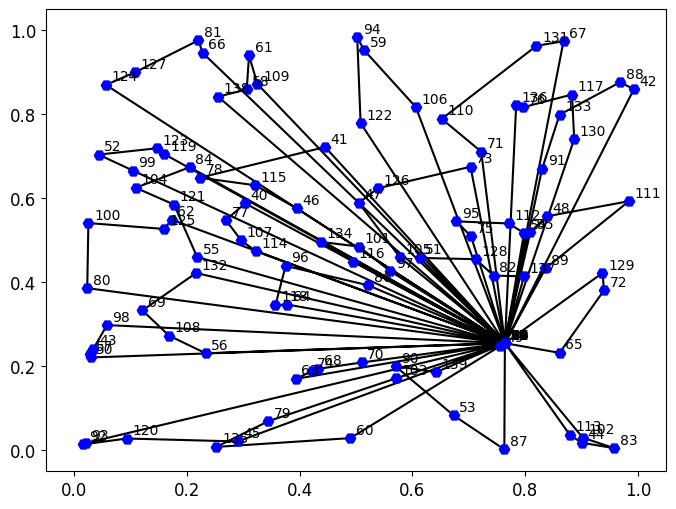

Linked list format (rec variable):
 tensor([ 25, 136,  33,  63,  85,  29,   2,  41, 122,  20,  93,   5, 132,  91,
         97, 113,  66,  54, 129,  87,  60,  55,  11,  40,  64,  26,  51,  67,
        105,  30,  31,  18,  15,   9,  99, 109,  12,  98,  62,  49,  77,  78,
          4,  57,  83,   0,  14, 126, 111,  17,  24, 128, 123,  90, 112, 121,
         10,  50, 138, 106, 135,  58, 125,  74, 118,  35,  81, 131,  70, 108,
          6,   3,  65,  21,  68,  37, 117, 107, 115, 103,   1, 127, 137, 102,
          7,  48,  23,  53,  42,  22, 139, 133, 120,  92,  59,  75,  86, 101,
         43,  52,  80, 134,  13,  28,  84,  47,  27, 114,  56,  61,  71,  89,
         95,  44,  38,  46,  19, 130,  96,  32,  45, 104,  94, 119,  36, 100,
         73, 124,  82,  72,  34, 110,  69,  88, 116,  79,  76,  39,   8,  16])

Here, the linked list format means:
edge 0-25 is in the solution
edge 1-136 is in the solution
edge 2-33 is in the solution
edge 3-63 is in the solution
edge 4-85 is in the solution


In [66]:
coordinates_first = batch['coordinates'][0]
plot_tour(solution_best[0], coordinates_first)
print('Linked list format (rec variable):\n', solution_best[0])
print('\nHere, the linked list format means:')
for i in range(10):
    print(f'edge {i}-{solution_best[0,i]} is in the solution')

real_seq = problem.get_order(solution_best, return_solution = True)
print('\nReal solution after decoding (node visited in sequence):\n', real_seq[0])
best_length = problem.get_costs(batch_aug_same, solution_best, get_context = False, check_full_feasibility = True)
print(best_length)